In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!pip install tensorflow keras

In [3]:
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')

In [6]:
x_train.shape

(60000, 28, 28, 1)

In [7]:
#normalise the x_train 

x_train = (x_train - 127.5) / 127.5


In [8]:
buffer_size = 60000
batch_size = 256 



In [9]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [10]:
# Build Generator 

def build_generator():
    network = tf.keras.Sequential()
    network.add(layers.Dense(units=7*7*256,use_bias=False,input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Reshape((7,7,256)))

    #7x7x128 
    network.add(layers.Conv2DTranspose(filters=128,kernel_size=(5,5),padding='same',use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #14x14x64
    network.add(layers.Conv2DTranspose(filters=64,kernel_size=(5,5),padding='same',strides=(2,2),use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #28x28x1
    network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5),padding='same',strides=(2,2),use_bias=True,activation='tanh'))

    network.summary()
    return network

In [11]:
generator = build_generator()

C:\Users\dhanu\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [12]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 3.2831469 , -0.05681133, -0.11024344, -1.0995358 ,  0.35132313,
         0.5125945 ,  1.6518047 , -0.40834644,  0.5137334 ,  0.8970436 ,
        -0.45098546,  0.2806092 , -0.07450177,  1.7896671 , -0.4191231 ,
         1.3714814 ,  1.5069079 ,  0.21966226, -1.0493487 ,  0.68458813,
        -1.0838464 , -0.19969404,  0.17943373,  0.18540825,  1.6349975 ,
         0.10695014, -0.9349933 ,  0.3360973 ,  0.964436  ,  0.60011125,
         0.5827926 ,  0.12398805,  1.1633953 ,  0.1147578 ,  0.7311492 ,
         1.719127  ,  1.6062617 ,  0.08384386,  0.20970263, -0.05050104,
         0.00718305, -0.09719871, -0.7473312 ,  0.6076164 , -0.5844123 ,
         0.27213973,  0.0564263 ,  1.017992  ,  0.11894021,  0.39673793,
         0.08660042,  0.38583845, -0.30811957,  0.7573429 ,  1.7378886 ,
         0.34825122,  0.47241595,  0.79649353,  0.01473597,  1.7403885 ,
         1.4404818 , -0.61216664,  0.7706473 , -0.44084162, -1.1683589 ,
 

In [13]:
generated_image = generator(noise,training=False)

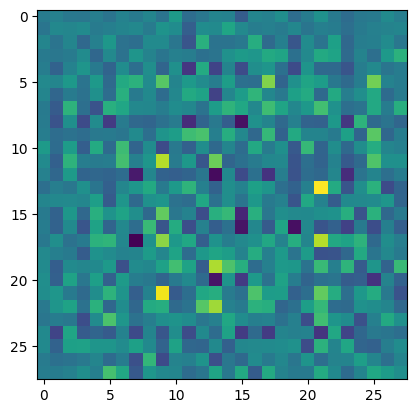

In [16]:
plt.imshow(generated_image[0,:,:,0])

In [18]:
#Building the discriminator

def build_discriminator():
    network = tf.keras.Sequential()

    #14x14x64 
    network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    #7*7*128 
    network.add(layers.Conv2DTranspose(filters=128,strides=(2,2),kernel_size=(5,5),padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    #4x4x256
    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    network.summary()
    return network

In [19]:
discriminator = build_discriminator()

C:\Users\dhanu\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,945 (1.17 MB)

 Trainable params: 306,945 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00021693]], dtype=float32)>

In [21]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992385506629944>

## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.

In [22]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [23]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667175292969>

In [24]:
def loss_generator(fake_output):
    g_loss = -1 * tf.math.reduce_mean(fake_output)
    return g_loss

In [32]:
def loss_discriminator(real_output,fake__output,gradient_penalty):
    c_lambda = 10 
    d_loss = tf.math.reduce_mean(fake__output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.
 
To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [26]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [29]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [30]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [31]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

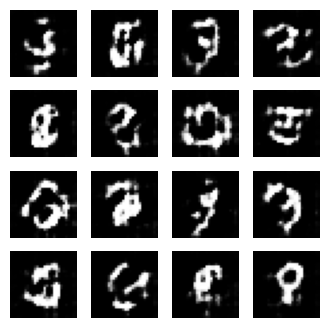

Time taken to process epoch 1 was 1457.0886693000793 seconds


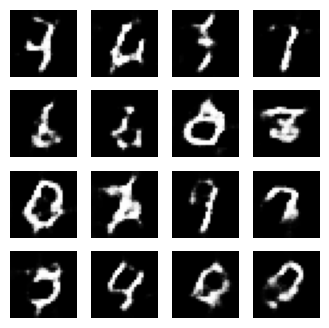

Time taken to process epoch 2 was 1411.2734043598175 seconds


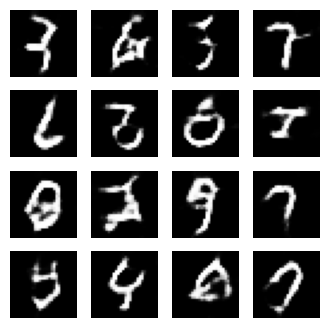

Time taken to process epoch 3 was 1382.092668056488 seconds


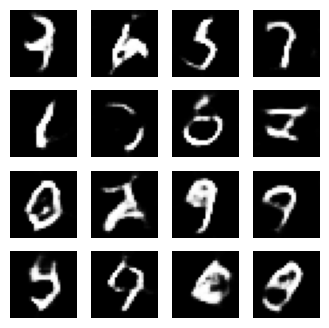

Time taken to process epoch 4 was 1270.531994342804 seconds


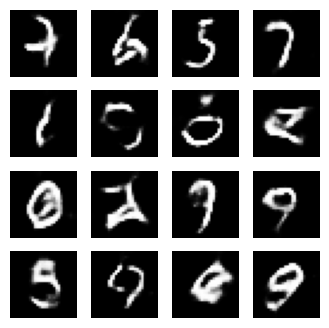

Time taken to process epoch 5 was 1255.062978029251 seconds


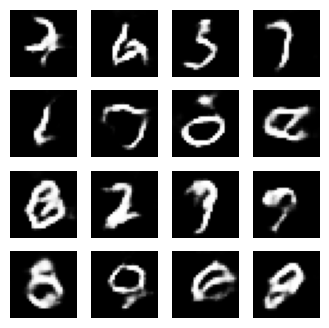

Time taken to process epoch 6 was 1259.1773393154144 seconds


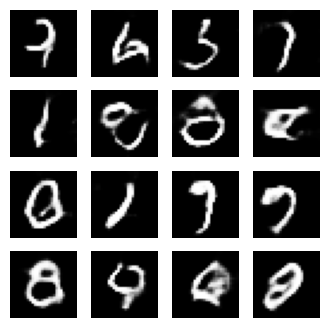

Time taken to process epoch 7 was 1258.932718038559 seconds


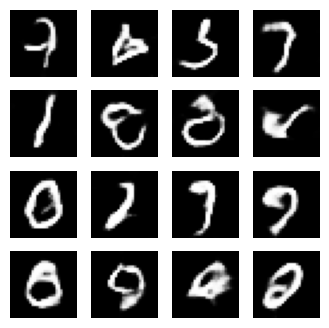

Time taken to process epoch 8 was 1260.7840824127197 seconds


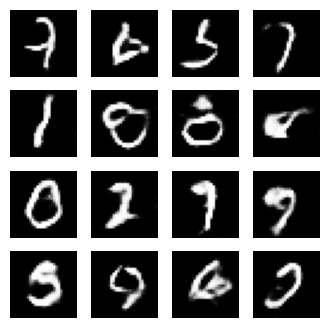

Time taken to process epoch 9 was 1259.0825860500336 seconds


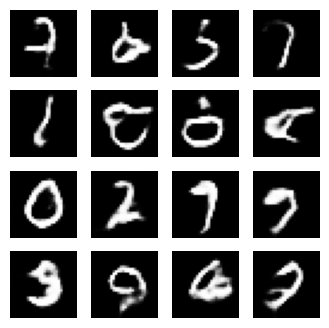

Time taken to process epoch 10 was 1232.60675406456 seconds


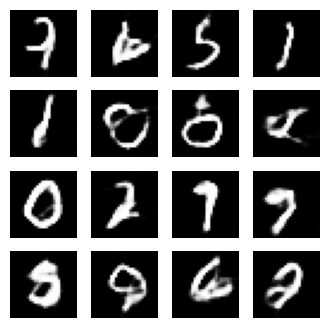

Time taken to process epoch 11 was 1320.0015251636505 seconds


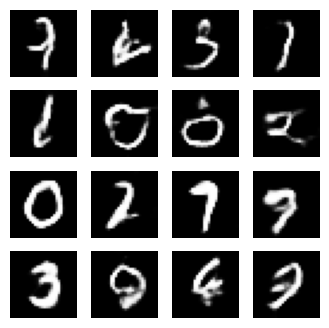

Time taken to process epoch 12 was 1269.6136331558228 seconds


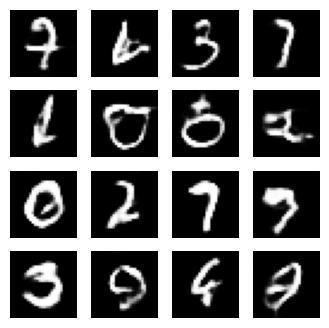

Time taken to process epoch 13 was 1230.5809602737427 seconds


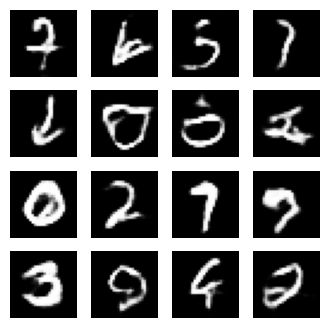

Time taken to process epoch 14 was 1341.8305668830872 seconds


KeyboardInterrupt: 

In [34]:
train(x_train, epochs)

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))



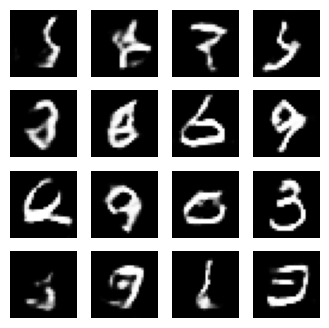

In [36]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')